In [1]:
import numpy as np
import pandas as pd
from scipy import stats,spatial,sparse
from sklearn import manifold,datasets
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
from numba.core.errors import NumbaDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
import phate
n_branch = 6
n_points = 500
gt_X, labels = phate.tree.gen_dla(n_branch=n_branch, branch_length=n_points, n_dim=10, sigma=0,seed=5) 

noise = np.random.normal(0, 2, gt_X.shape) # 2
tree_X = gt_X + noise
tree_labels = np.array([i // n_points for i in range(n_branch * n_points)])

In [4]:
import pygsp

euc_dist = spatial.distance.squareform(spatial.distance.pdist(gt_X,metric = 'euclidean'))
graph = pygsp.graphs.NNGraph(gt_X, k = 10)
A = graph.A.toarray()
euc_dist[A == 0] = 0
tree_geodesic_dist = sparse.csgraph.shortest_path(euc_dist, method="auto", directed=False)

Using s_gd2 for MDS. None


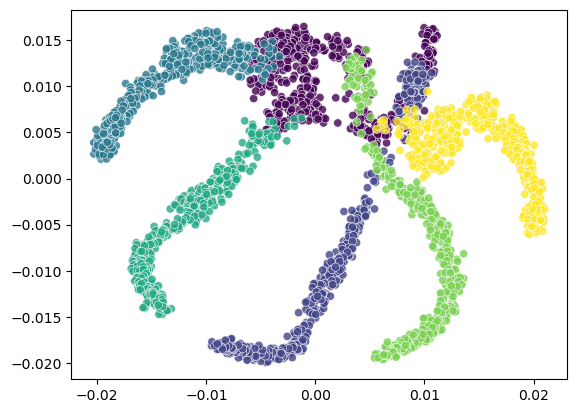

In [5]:
from heatgeo.embedding import HeatGeo
emb_op = HeatGeo(knn=5)
Y_heatgeo = emb_op.fit_transform(tree_X)
# plt.scatter(emb[:, 0],emb[:, 1], c=t,s =5, cmap = "viridis")

sns.scatterplot(x=Y_heatgeo[:, 0], y=Y_heatgeo[:, 1], hue=labels, palette="viridis", alpha=0.8)
plt.legend().remove()

In [6]:
heatgeo_dist = emb_op.dist

In [7]:
def correlation(matrix_A, matrix_B):
    
    from scipy import stats
    n_samples = matrix_A.shape[0]
    pearsonr_correlation_list = []
    spearmanr_correlation_list = []
    for i in range(n_samples):
        pearsonr_res = stats.pearsonr(matrix_A[i], matrix_B[i])
        pearsonr_correlation_list.append(pearsonr_res.statistic) 
        spearmanr_res = stats.spearmanr(matrix_A[i], matrix_B[i])
        spearmanr_correlation_list.append(spearmanr_res.statistic)
        
    pearsonr_correlation_mean = np.mean(pearsonr_correlation_list)
    spearmanr_correlation_mean = np.mean(spearmanr_correlation_list)
    pearsonr_correlation_interval = stats.norm.interval(confidence=0.95, loc=pearsonr_correlation_mean, scale=stats.sem(pearsonr_correlation_list))
    spearmanr_correlation_interval = stats.norm.interval(confidence=0.95, loc=spearmanr_correlation_mean, scale=stats.sem(spearmanr_correlation_list))
    
    correlation_mean = [pearsonr_correlation_mean,spearmanr_correlation_mean]
    correlation_interval = [pearsonr_correlation_interval,spearmanr_correlation_interval]
    
    pearsonr_correlation = [pearsonr_correlation_mean,pearsonr_correlation_interval]
    spearmanr_correlation = [spearmanr_correlation_mean,spearmanr_correlation_interval]
    
    return pearsonr_correlation_list,spearmanr_correlation_list,pearsonr_correlation,spearmanr_correlation 

In [8]:
corr = correlation(tree_geodesic_dist,heatgeo_dist)
corr[2:]

([0.7982445398256771, (0.7955423549946543, 0.8009467246566999)],
 [0.884334156825289, (0.8825908667792933, 0.8860774468712848)])

In [9]:
tti = manifold.trustworthiness(heatgeo_dist,tree_X,n_neighbors=100)
tti

0.9929714312452477

In [10]:
np.savetxt("tree_Y_heatgeo.csv",Y_heatgeo,delimiter=',')

The code runs 6s.


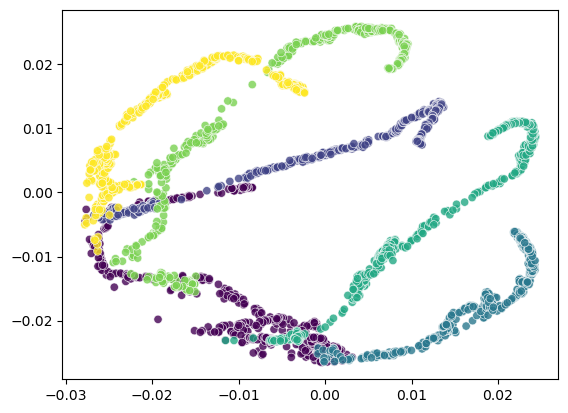

In [11]:
import phate

start_time = time.time()
phate_operator = phate.PHATE(verbose=False,random_state=0)
Y_phate = phate_operator.fit_transform(tree_X)
end_time = time.time()
print('The code runs {:.0f}s.'.format(end_time - start_time))

sns.scatterplot(x=Y_phate[:, 0], y=Y_phate[:, 1], hue=labels, palette="viridis", alpha=0.8)
plt.legend().remove()

In [12]:
phate_dists = spatial.distance.squareform(spatial.distance.pdist(phate_operator.diff_potential,metric = 'euclidean'))

In [13]:
corr = correlation(tree_geodesic_dist,phate_dists)
corr[2:]

([0.6150345597914977, (0.6099849790135843, 0.6200841405694111)],
 [0.36176546789112596, (0.34861968274466015, 0.37491125303759176)])

In [14]:
tti = manifold.trustworthiness(phate_dists,tree_X,n_neighbors=100)
tti

0.9912776919927473

In [15]:
np.savetxt("tree_Y_phate.csv",Y_phate,delimiter=',')

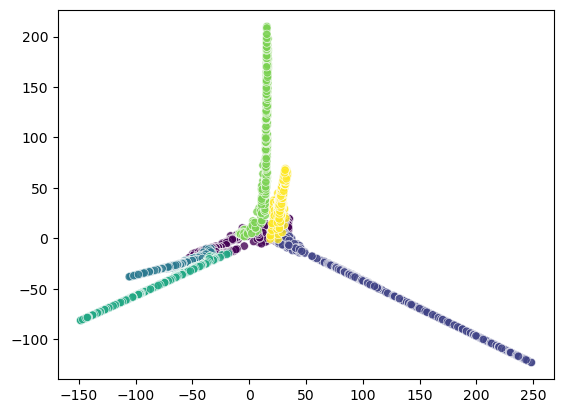

In [16]:
isomap_operator = manifold.Isomap(n_components=2)
Y_isomap = isomap_operator.fit_transform(tree_X)

sns.scatterplot(x=Y_isomap[:, 0], y=Y_isomap[:, 1], hue=labels, palette="viridis", alpha=0.8)
plt.legend().remove()

In [17]:
isomap_Y_dists = spatial.distance.squareform(spatial.distance.pdist(Y_isomap,metric = 'euclidean'))

In [18]:
tree_isomap_dists = isomap_operator.dist_matrix_

corr = correlation(tree_geodesic_dist,tree_isomap_dists)
corr[2:]

([0.8786240715141796, (0.8767111582927407, 0.8805369847356186)],
 [0.8920164594227176, (0.8903484997779192, 0.893684419067516)])

In [19]:
tti = manifold.trustworthiness(tree_isomap_dists,tree_X,n_neighbors=100)
tti

0.9914609007428203

In [20]:
np.savetxt("tree_Y_isomap.csv",Y_isomap,delimiter=',')

The code runs 8s.


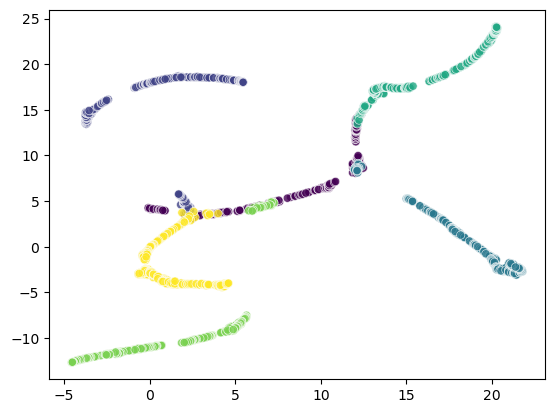

In [21]:
from umap import UMAP

start_time = time.time()
reducer = UMAP(random_state=0) 
Y_umap = reducer.fit_transform(tree_X)
end_time = time.time()
print('The code runs {:.0f}s.'.format(end_time - start_time))

sns.scatterplot(x=Y_umap[:, 0], y=Y_umap[:, 1], hue=labels, palette="viridis", alpha=0.8)
plt.legend().remove()

In [22]:
np.savetxt("tree_Y_umap.csv",Y_umap,delimiter=',')

The code runs 6s.


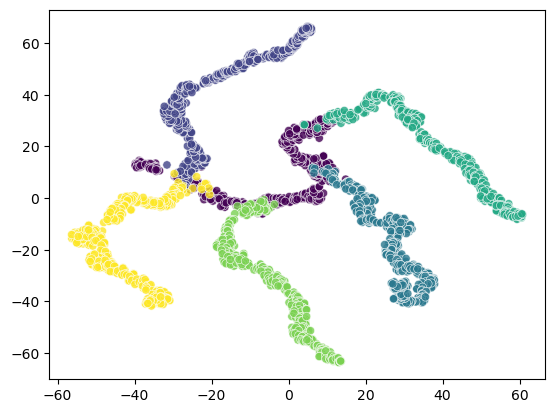

In [23]:
start_time = time.time()
tsne_operator = manifold.TSNE(random_state=0)
Y_tsne = tsne_operator.fit_transform(tree_X)
end_time = time.time()
print('The code runs {:.0f}s.'.format(end_time - start_time))

sns.scatterplot(x=Y_tsne[:, 0], y=Y_tsne[:, 1], hue=labels, palette="viridis", alpha=0.8)
plt.legend().remove()

In [24]:
np.savetxt("tree_Y_tsne.csv",Y_tsne,delimiter=',')

In [25]:
import scanpy as sc

In [26]:
ad = sc.AnnData(X=tree_X)
ad.obs['tree_labels'] = tree_labels

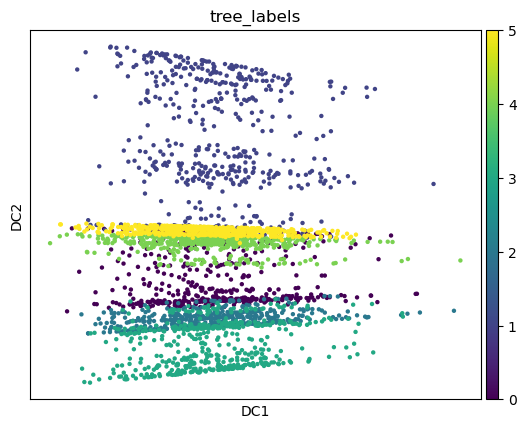

In [27]:
sc.pp.neighbors(ad, 10)
sc.tl.diffmap(ad, 10)
sc.pl.diffmap(ad,color=['tree_labels'])

In [28]:
X_diffmap = ad.obsm['X_diffmap']
np.savetxt("tree_Y_dm.csv",X_diffmap[:,[0,1]],delimiter=',')

In [29]:
Y_dists = spatial.distance.squareform(spatial.distance.pdist(X_diffmap,metric = 'euclidean'))
corr = correlation(tree_geodesic_dist,Y_dists)
corr[2:]

([0.7268268853895103, (0.7239243502332392, 0.7297294205457815)],
 [0.6807140222726691, (0.6773643530706822, 0.684063691474656)])

In [30]:
tti = manifold.trustworthiness(Y_dists,tree_X,n_neighbors=100)
tti

0.9896607194244604

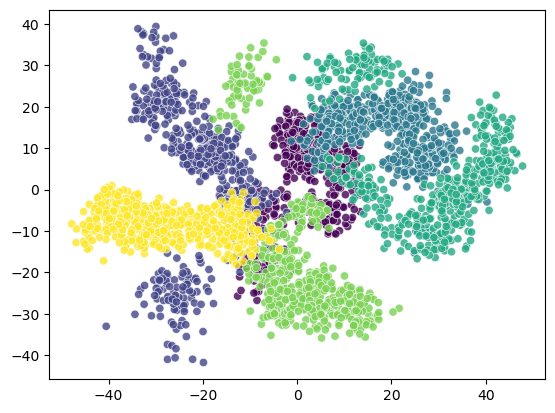

In [31]:
mds_operator = manifold.MDS(random_state=0)
Y_mds = mds_operator.fit_transform(tree_X)

sns.scatterplot(x=Y_mds[:, 0], y=Y_mds[:, 1], hue=labels, palette="viridis", alpha=0.8)
plt.legend().remove()
np.savetxt("tree_Y_mds.csv",Y_mds,delimiter=',')